In [65]:
import numpy as np
import bilby
from sympy import sin,cos,log,sqrt
from astropy import constants as const
import matplotlib.pyplot as plt

import sys
import os
import six

OrbitRadiusInS = 1e8 /const.c.value    # 1e5 km
MearthInS      = const.M_earth.value*const.G.value/const.c.value**3
OrbitPeriodInS = 2*np.pi*np.sqrt(OrbitRadiusInS**3/MearthInS)
YearInS  = 31536000.0   # one year in [s]

c = 299792458.0  # m/s
G = 6.67*1.0e-11 
AU = 1.5e+11
parsec = 3.085677581491367e+16  # m
solar_mass = 1.9885469549614615e+30  # Kg

In [107]:
def InspiralWaveform(t, m1, m2, DL, Tc, iota, phic, psi, thetaS, phiS):
    c = 299792458.0  # m/s
    G = 6.67*1.0e-11 
    AU = 1.5e11
    fm = 1.0/YearInS
    eta = m1*m2/(m1+m2)**2  # symmetric mass ratio 
    m = m1+m2     # total mass
    tau = c**3*eta/(5*G*m)*(Tc-t);
    wt = c**3/(8*G*m)*(tau**(-3/8)+(743/2688+11/32*eta)*tau**(-5/8)-3*np.pi/10*tau**(-3/4)\
        +(1855099/14450688+56975/258048*eta+371/2048*eta**2)*tau**(-7/8))
    PHI = -2/eta*(tau**(5/8)+(3715/8064+55/96*eta)*tau**(3/8)-3*np.pi/4*tau**(1/4)\
        +(9275495/14450688+284875/258048*eta+1855/2048*eta**2)*tau**(1/8))\
        +wt*AU/c*sin(thetaS)*cos(2*np.pi*fm*t-phiS)      # phi_Doppler
    x = (G*m*wt/c**3)**(2/3)
    hplus = 2*G*m*eta/(c**2*DL)*(1+cos(iota)**2)*x*cos(PHI+phic)
    hcros = -4*G*m*eta/(c**2*DL)*cos(iota)*x*sin(PHI+phic)
    return hplus, hcros

In [119]:
def Dplus_TQ(t,thetaS,phiS):
    """For TianQin (one Michelson interferometer): (thetaS,phiS) is location of source,
    (thJ,phJ) is latitude and longitude of J0806 in heliocentric-ecliptic frame"""
    thJ  = 1.65273
    phJ  = 2.10213
    kap = 2*np.pi/OrbitPeriodInS* t
#    kap = 2*np.pi/YearInS* t(f,theta)
    return np.sqrt(3.)/32*(8*cos(2*kap) *((3 + cos(2*thetaS)) *sin(2*(phiS - phJ))*  
            cos(thJ) + 2*sin(thJ) *sin(phiS - phJ)*sin(2*thetaS))- 2*sin(2*kap)* (3 +               
            cos(2*(phiS - phJ))*(9 + cos(2*thetaS)*(3 + cos(2*thJ))) -6 *cos(2*thJ)*(sin(phiS - phJ))**2 -               
            6* cos(2*thetaS)*(sin(thJ))**2 + 4*cos(phiS - phJ)*sin(2*thJ)*sin(2*thetaS))) 

def Dcros_TQ(t,thetaS,phiS):
    """For TianQin (one Michelson interferometer): (thetaS,phiS) is location of source, 
    (thJ,phJ) is latitude and longitude of J0806 in heliocentric-ecliptic frame"""
    thJ  = 1.65273
    phJ  = 2.10213
    kap = 2*np.pi/OrbitPeriodInS* t
#    kap = 2*np.pi/YearInS* t(f,theta)
    return np.sqrt(3.)/4*(-4*cos(2*kap)*(cos(2*(phiS-phJ))*cos(thJ)*cos(thetaS)+                 
            cos(phiS-phJ)*sin(thetaS)*sin(thJ))+sin(2*kap)*(cos(thetaS)*(3+cos(2*thJ))*sin(2*(phJ-phiS))+                
            2*sin(phJ-phiS)*sin(thetaS)*sin(2*thJ)))

def Fplus_TQ(t,thetaS,phiS,psi):
    """antenna pattern function for '+' mode"""
    return (cos(2*psi)*Dplus_TQ(t,thetaS,phiS)-sin(2*psi)*Dcros_TQ(t,thetaS,phiS))/2.

def Fcros_TQ(t,thetaS,phiS,psi):
    """antenna pattern function for '×' mode"""
    return (sin(2*psi)*Dplus_TQ(t,thetaS,phiS)+cos(2*psi)*Dcros_TQ(t,thetaS,phiS))/2.


In [44]:
m1 = 1.0e6*solar_mass
m2 = 2.0e5*solar_mass
Tc = 1.04*YearInS
DL = 11.01*1.0e9*parsec


thetaS = 1.6398
phiS = 4.1226
psi = 1.373
iota = 0.7647
phic = 0.9849

class InputPara(object):

    def __init__(self, m1, m2, DL, Tc, iota, phic, psi, thetaS, phiS):
        self.m1 = m1
        self.m2 = m2
        self.DL = DL
        self.Tc = Tc
        self.iota = iota
        self.phic = phic
        self.psi = psi
        self.thetaS = thetaS
        self.phiS = phiS
    
theta = InputPara(m1, m2, DL, Tc, iota, phic, psi, thetaS, phiS)  

32768


Text(0.5, 1.0, 'TianQin Antenna pattern function')

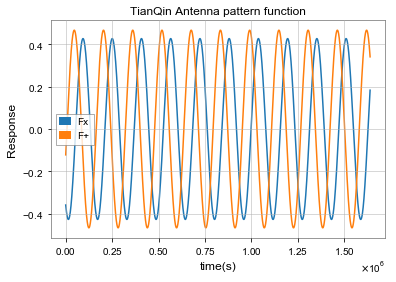

In [5]:
Dplus = []
Dcros = []
Fplus = []
Fcros = []

duration = 1638400
time = np.arange(0, duration, 50)
print(len(time))

for i in time:
    Dp = Dplus_TQ(i,theta)
    Dc = Dcros_TQ(i,theta)
    Fp = Fplus_TQ(i,theta)
    Fc = Fcros_TQ(i,theta)
    Dplus.append(Dp)
    Dcros.append(Dc)
    Fplus.append(Fp)
    Fcros.append(Fc)

Dplus = np.array(Dplus)         #Convert list to array
Dcros = np.array(Dcros)         #Convert list to array
Fplus = np.array(Fplus)         #Convert list to array
Fcros = np.array(Fcros)         #Convert list to array

fig = plt.plot(time, Fcros, label='Fx')
fig = plt.plot(time, Fplus, label='F+')
plt.xlabel('time(s)')
plt.ylabel('Response')
plt.legend()
plt.title('TianQin Antenna pattern function')

In [6]:
hplus = []
hcros = []
for i in time:
    hp, hc = InspiralWaveform(i,theta)
    hplus.append(hp)
    hcros.append(hc)
    

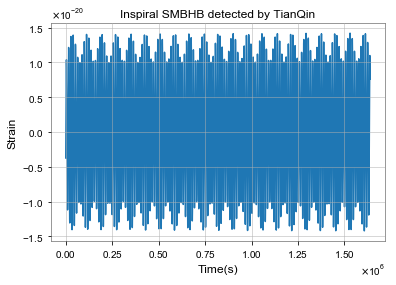

In [7]:
hplus = np.array(hplus)  # convert list to array
hcros = np.array(hcros)  # convert list to array

strain = Fplus*hplus + Fcros*hcros

plt.plot(time, strain, label='strain')
plt.xlabel('Time(s)')
plt.ylabel('Strain')
plt.title('Inspiral SMBHB detected by TianQin')

N = len(time)
mean = 0
sigma = 1.0e-21
noise   = sigma*np.random.randn(N)

# plt.hist(noise,50)
# plt.show()

data_time = strain + noise

# Checking signal in frequency domain

In [ ]:
# # def create_frequency_series(sampling_frequency, duration):
# #     number_of_samples = int(np.round(duration * sampling_frequency))
# #     number_of_frequencies = int(np.round(number_of_samples / 2) + 1)

# #     return np.linspace(start=0,
# #                        stop=sampling_frequency / 2,
# #                        num=number_of_frequencies)

# # sampling_frequency = 1/50.0 
# # data_fd = np.fft.fft(data_time)    # data in frequency
# # data_fd = data_fd[0:int((len(data_fd))/2+1)]
# # ff = create_frequency_series(2.0e-2, 1638400)

# # hplus_fre = np.fft.fft(hplus)
# # hplus_fre = hplus_fre[0:int((len(hplus_fre))/2+1)]
# # hcros_fre = np.fft.fft(hcros)
# # hcros_fre = hplus_fre[0:int((len(hcros_fre))/2+1)]

# # data_power_spectral_density = data_fd*np.transpose(np.conjugate(data_fd)/duration)

# def log_likelihood(duration, data_time, theta, t):
#     """
#     Returns
#     ------
#     float: The real part of the log-likelihood for this interferometer
#     """
# #     noise_power_spectral_density = 2*sigma**2*50
#     hplus, hcros = np.array(InspiralWaveform(t,theta))
#     ht = np.array(Fplus_TQ(t,theta))*np.array(hplus) + np.array(Fcros_TQ(t,theta))*np.array(hcros)
# #     hf = np.fft.fft(hf)
# #     hf = hf[0:int((len(hf))/2+1)]
    
#     log_l = - 2. / duration * np.vdot(data_time - ht,(data_time - ht))
#     return log_l.real

# def log_likelihood(duration, data_time, theta, t):
#     """
#     Returns
#     ------
#     float: The real part of the log-likelihood for this interferometer
#     """
# #     noise_power_spectral_density = 2*sigma**2*50
#     hplus, hcros = np.array(InspiralWaveform(t,theta))
#     ht = np.array(Fplus_TQ(t,theta))*np.array(hplus) + np.array(Fcros_TQ(t,theta))*np.array(hcros)
# #     hf = np.fft.fft(hf)
# #     hf = hf[0:int((len(hf))/2+1)]
    
#     log_l = - 2. / duration * np.vdot(data_time - ht,(data_time - ht))
#     return log_l.real

# fig, ax = plt.subplots(figsize=(9,6))
# ax.plot(ff, np.sqrt(abs(data_power_spectral_density)))
# plt.yscale('log')
# plt.xscale('log')
# ax.set_xlim([5.0e-6, 5.0e-4])
# plt.xlabel('frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.title('fd data')

# # noise_power_spectrum_density = 2*sigma**2*50  #approximate
# noise_power_spectral_density = np.fft.fft(noise)*np.transpose(np.conjugate(np.fft.fft(noise)))/duration
# noise_power_spectral_density = noise_power_spectral_density[0:int((len(noise_power_spectral_density))/2+1)]
# hf = hplus_fre + hcros_fre
# snr = np.sqrt(np.real(np.trapz(abs(hf)**2/noise_power_spectral_density, ff)))

# print(snr)

# def noise_weighted_inner_product(aa, bb, power_spectral_density, duration):
#     """
#     Calculate the noise weighted inner product between two arrays.
    
#     Returns
#     ------
#     Noise-weighted inner product.
#     """

#     integrand = np.conj(aa) * bb / power_spectral_density
#     return 4 / duration * np.sum(integrand)

# def log_likelihood(duration, data_fd, hf, noise_power_spectral_density):
#     """
#     Returns
#     ------
#     float: The real part of the log-likelihood for this interferometer
#     """
    
#     log_l = - 2. / duration * np.vdot(data_fd - hf,(data_fd - hf) /noise_power_spectral_density)
#     return log_l.real

# Loglikelihood = log_likelihood(duration, data_fd, hf, noise_power_spectral_density)
# print(Loglikelihood)

# Cpnest 

In [8]:
# def log_likelihood(duration, data_time, theta, t):
#     """
#     Returns
#     ------
#     float: The real part of the log-likelihood for this interferometer
#     """
# #     noise_power_spectral_density = 2*sigma**2*50
#     hplus, hcros = np.array(InspiralWaveform(t,theta))
#     ht = np.array(Fplus_TQ(t,theta))*np.array(hplus) + np.array(Fcros_TQ(t,theta))*np.array(hcros)
# #     hf = np.fft.fft(hf)
# #     hf = hf[0:int((len(hf))/2+1)]
    
#     log_l = - 2. / duration * np.vdot(data_time - ht,(data_time - ht))
#     return log_l.real

In [45]:
# def logposterior(duration, data_time, theta, t):
#     """
#     The natural logarithm of the joint posterior.

#     Args:
#         theta (tuple): a sample containing individual parameter values
#         data (list): the set of data/observations
#         sigma (float): the standard deviation of the data points
#         x (list): the abscissa values at which the data/model is defined
#     """

#     lp = logprior(theta) # get the prior

#     # if the prior is not finite return a probability of zero (log probability of -inf)
#     if not np.isfinite(lp):
#         return -np.inf

#     # return the likeihood times the prior (log likelihood plus the log prior)
#     return lp + log_likelihood(duration, data_time, theta, t)

In [123]:
def log_likelihood(theta):
    """
    Returns
    ------
    float: The real part of the log-likelihood for this interferometer
    """
    
    m1, m2, DL, Tc, iota, phic, psi, thetaS, phiS = theta
    hplus = []
    hcros = []
    for i in time:
        hplus_temp, hcros_temp = np.array(InspiralWaveform(i,m1, m2, DL, Tc, iota, phic, psi, thetaS, phiS))
        hplus.append(hplus_temp)
        hcros.append(hcros_temp)
    
    ht = np.array(Fplus_TQ(i,thetaS,phiS,psi))*np.array(hplus) + np.array(Fcros_TQ(i,thetaS,phiS,psi))*np.array(hcros)
    
    log_l = np.real(- 2. / duration * np.vdot(data_time - ht,(data_time - ht)))
    return log_l

In [124]:
def prior_transform(theta):

    # unpack the model parameters from the tuple
#     m1,m2,DL,Tc,iota,phic,psi,thetaS,phiS=theta
    m1prime, m2prime, DLprime, Tcprime, iotaprime, phicprime, psiprime, thetaSprime, phiSprime = theta
    
    # uniform prior on c
    m1min = 5.0e5*solar_mass   # lower range of prior
    m1max = 5.0e6*solar_mass   # upper range of prior
    
    m2min = 1.0e5*solar_mass   # lower range of prior
    m2max = 5.0e5*solar_mass   # upper range of prior
     
    DLmin = 10*1.0e9*parsec
    DLmax = 15*1.0e9*parsec
    
    Tcmin = 0.9*YearInS
    Tcmax = 1.2*YearInS
    
    iotamin = 0
    iotamax = np.pi
    
    phicmin = 0
    phicmax = 2*np.pi
     
    psimin = 0
    psimax = 2*np.pi
    
    thetaSmin = 0
    thetaSmax = np.pi
    
    phiSmin = 0
    phiSmax = 2*np.pi
    
    m1 = m1prime*(m1max-m1min)+m1min
    m2 = m2prime*(m2max-m2min)+m2min
    DL = DLprime*(DLmax-DLmin)+DLmin
    TC = Tcprime*(Tcmax-Tcmin)+Tcmin
    iota = iotaprime*(iotamax - iotamin)+iotamin
    phic = phicprime*(phicmax-phicmin)+phicmin
    psi = psiprime*(psimax-psimin)+psimin
    thetaS = thetaSprime*(thetaSmax - thetaSmin)+thetaSmin
    phiS = phiSprime*(phiSmax-phiSmin)+phiSmin

    return m1, m2, DL, Tc, iota, phic, psi, thetaS, phiS

In [ ]:
# import nestle
import nestle
from datetime import datetime
print('Nestle version: {}'.format(nestle.__version__))

nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 9        # two parameters
tol = 0.1        # the stopping criterion

t0 = datetime.now()
res = nestle.sample(log_likelihood, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol)
t1 = datetime.now()


Nestle version: 0.2.0


In [ ]:
timeultranest = (t1-t0)
print("Time taken to run 'UltraNest' is {} seconds".format(timeultranest))

In [ ]:
logZultranest = result['logZ']        # value of logZ
logZerrultranest = result['logZerr']  # estimate of the statistcal uncertainty on logZ

# output marginal likelihood
print(six.u('Marginalised evidence is {} \u00B1 {}'.format(logZultranest, logZerrultranest)))

In [ ]:
nsamples = np.array([xi for ui, xi, Li, logwidth in result['weights']])
probs = np.array([Li + logwidth for ui, xi, Li, logwidth in result['weights']])
probs = np.exp(probs - probs.max())

keepidx = np.where(np.random.rand(len(probs)) < probs)[0]

samples_ultranest = nsamples[keepidx,:]

resdict['multranest_mu'] = np.mean(samples_ultranest[:,0])      # mean of m samples
resdict['multranest_sig'] = np.std(samples_ultranest[:,0])      # standard deviation of m samples
resdict['cultranest_mu'] = np.mean(samples_ultranest[:,1])      # mean of c samples
resdict['cultranest_sig'] = np.std(samples_ultranest[:,1])      # standard deviation of c samples
resdict['ccultranest'] = np.corrcoef(samples_ultranest.T)[0,1]  # correlation coefficient between parameters
resdict['ultranest_npos'] = len(samples_ultranest)              # number of posterior samples
resdict['ultranest_time'] = timeultranest                       # run time
resdict['ultranest_logZ'] = logZultranest                       # log marginalised likelihood
resdict['ultranest_logZerr'] = logZerrultranest                 # uncertainty on log(Z)

# plot using corner.py
plotposts(samples_ultranest)

print('Number of posterior samples is {}'.format(samples_ultranest.shape[0]))